# UUID Exploration Notebook

The purpose of this notebook is to explore characteristics of the UUIDs in the waze.csv data.

- number of UUIDs
- time durations of UUIDs
- distribution across days
- distribution across time of day
- distribution across road type

TODO:
- can we determine if multiple UUIDs occur in the same congestion event (filter by street and datetime?)
- length of linestrings associated with each UUID - ST_NumPoints(geom)
- determine if UUIDs that occur many times constitute all of the UUIDs for those days

Feature Engineering ideas:
- add time duration of UUID
- average delay, level, etc.?

In [1]:
import numpy as np
import pandas as pd
import psycopg2 as pg

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# replace database inputs as appropriate
conn_str = "host={} dbname={} user={} password={}".format('localhost', 'waze', 'postgres', 'kilgore431Htrae')
conn = pg.connect(conn_str)

In [3]:
uuid_df = pd.read_sql('select uuid, waze_timestamp, street, road_type, length, level, delay, ST_AsText(geom) as linestring, ST_NumPoints(geom) as linestring_length from congestion', con=conn)

In [4]:
uuid_df.dtypes

uuid                          int64
waze_timestamp       datetime64[ns]
street                       object
road_type                     int64
length                        int64
level                         int64
delay                         int64
linestring                   object
linestring_length             int64
dtype: object

In [5]:
# extract day of week, date, time, and 15 minute interval timestamp
import datetime
uuid_df['dow'] = uuid_df['waze_timestamp'].dt.dayofweek
uuid_df['date'] = uuid_df['waze_timestamp'].dt.date
uuid_df['timeOnly'] = uuid_df['waze_timestamp'].dt.time
uuid_df['interval'] = uuid_df['waze_timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))
uuid_df['timeOnlyInterval'] = uuid_df['interval'].dt.time

In [6]:
uuid_df.head(10)

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
0,348279374,2017-02-24 08:47:01,Rosecrans St,6,934,4,464,"LINESTRING(-117.205146 32.75087,-117.205464 32...",21,4,2017-02-24,08:47:01,2017-02-24 08:45:00,08:45:00
1,348764673,2017-02-24 08:47:01,to SR-163 N,4,487,3,101,"LINESTRING(-117.154769 32.724825,-117.154914 3...",14,4,2017-02-24,08:47:01,2017-02-24 08:45:00,08:45:00
2,348536095,2017-02-24 08:47:01,Via Rancho Pkwy,7,637,2,90,"LINESTRING(-117.074149 33.070687,-117.071046 3...",5,4,2017-02-24,08:47:01,2017-02-24 08:45:00,08:45:00
3,40791027,2017-02-24 08:51:49,Hoover Ave,1,100,5,-1,"LINESTRING(-117.104636 32.664031,-117.10495 32...",2,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
4,36971633,2017-02-24 08:51:49,Hoover Ave,1,100,5,-1,"LINESTRING(-117.10495 32.664898,-117.104636 32...",2,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
5,353993967,2017-02-24 08:51:49,Civic Center Dr,7,303,3,114,"LINESTRING(-117.113431 32.669224,-117.112735 3...",4,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
6,349622483,2017-02-24 08:51:49,Civic Center Dr,7,252,3,98,"LINESTRING(-117.10985 32.670215,-117.110362 32...",3,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
7,345243533,2017-02-24 08:51:49,I-5 N,3,3118,3,302,"LINESTRING(-117.105697 32.654936,-117.106827 3...",32,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
8,349775633,2017-02-24 08:51:49,Beyer Blvd,7,475,3,128,"LINESTRING(-117.060709 32.565916,-117.061494 3...",7,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
9,349685702,2017-02-24 08:51:49,La Media Rd,2,1462,2,118,"LINESTRING(-116.987868 32.634107,-116.987863 3...",20,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00


In [7]:
uuid_df.shape

(2260990, 14)

In [8]:
len(uuid_df['uuid'].unique())

826660

In [9]:
len(uuid_df['waze_timestamp'].unique())

33628

# Look into the UUIDs with the highest counts

##### Questions:  
What's up with the most frequent 5 UUIDs each occurring the same number of times?  Same for those that occur 3434 times, and 2577 times?

In [10]:
uuid_df['uuid'].value_counts().head(20)

973869277     3760
977509981     3760
975567875     3760
977765890     3760
977507871     3760
37573010      3434
38872818      3434
36972843      3434
36971633      3434
40791027      3434
68737532      3215
69778079      3215
1136612483    2742
1164790480    2577
1164792200    2577
1164792481    2577
1165912218    2577
1164792860    2577
1165392199    2577
1168272807    2577
Name: uuid, dtype: int64

In [11]:
top_counts = uuid_df['uuid'].value_counts().index.values
top_counts

array([ 973869277,  977509981,  975567875, ..., 1919658487, 2016137720,
       2043431543])

In [12]:
uuid_df[uuid_df['uuid']==top_counts[0]]

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
1320525,973869277,2017-05-07 02:26:48,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,02:26:48,2017-05-07 02:15:00,02:15:00
1320541,973869277,2017-05-07 02:31:35,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,02:31:35,2017-05-07 02:30:00,02:30:00
1320556,973869277,2017-05-07 02:36:23,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,02:36:23,2017-05-07 02:30:00,02:30:00
1320575,973869277,2017-05-07 02:42:22,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,02:42:22,2017-05-07 02:30:00,02:30:00
1320590,973869277,2017-05-07 02:51:57,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,02:51:57,2017-05-07 02:45:00,02:45:00
1320606,973869277,2017-05-07 02:53:09,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,02:53:09,2017-05-07 02:45:00,02:45:00
1320620,973869277,2017-05-07 02:56:44,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,02:56:44,2017-05-07 02:45:00,02:45:00
1320637,973869277,2017-05-07 03:01:32,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,03:01:32,2017-05-07 03:00:00,03:00:00
1320652,973869277,2017-05-07 03:06:19,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,03:06:19,2017-05-07 03:00:00,03:00:00
1320670,973869277,2017-05-07 03:12:19,Avenida de la Playa,2,55,5,-1,"LINESTRING(-117.256599 32.85396,-117.257154 32...",2,6,2017-05-07,03:12:19,2017-05-07 03:00:00,03:00:00


In [13]:
uuid_df[uuid_df['uuid'].isin(top_counts[:5])]['linestring'].unique()

array(['LINESTRING(-117.257154 32.854129,-117.256599 32.85396)',
       'LINESTRING(-117.258093 32.85436,-117.257154 32.854129)',
       'LINESTRING(-117.257154 32.854129,-117.258093 32.85436)',
       'LINESTRING(-117.256599 32.85396,-117.257154 32.854129)',
       'LINESTRING(-117.030703 32.745061,-117.030715 32.745036,-117.030648 32.744887,-117.030609 32.744804,-117.030597 32.744723,-117.030614 32.74468,-117.030683 32.744645,-117.031023 32.744636,-117.031166 32.744619)'], dtype=object)

In [14]:
# function to get info about a UUID
def getUUIDinfo(u):
    tmp_df = uuid_df[uuid_df['uuid'] == u]
    print 'uuid =', u
    print 'occurrences =', tmp_df.shape[0]
    print 'min time =', tmp_df['waze_timestamp'].min()
    print 'max time =', tmp_df['waze_timestamp'].max()
    print 'streets =', np.unique(tmp_df['street'].values)
    print 'road types =', np.unique(tmp_df['road_type'].values)
    print 'delays =', np.unique(tmp_df['delay'].values)
    print 'levels =', np.unique(tmp_df['level'].values)
    print 'number of unique linestrings =', len(tmp_df['linestring'].unique())
    if len(tmp_df['linestring'].unique()) == 1:
        print 'linestring =',tmp_df['linestring'].unique()
    print '\n'

In [15]:
# check top counts
map(getUUIDinfo, top_counts[:10]);

uuid = 973869277
occurrences = 3760
min time = 2017-05-07 02:26:48
max time = 2017-05-20 04:57:19
streets = ['Avenida de la Playa']
road types = [2]
delays = [-1]
levels = [5]
number of unique linestrings = 1
linestring = ['LINESTRING(-117.256599 32.85396,-117.257154 32.854129)']


uuid = 977509981
occurrences = 3760
min time = 2017-05-07 02:26:48
max time = 2017-05-20 04:57:19
streets = ['North Ave']
road types = [1]
delays = [-1]
levels = [5]
number of unique linestrings = 1
linestring = [ 'LINESTRING(-117.030703 32.745061,-117.030715 32.745036,-117.030648 32.744887,-117.030609 32.744804,-117.030597 32.744723,-117.030614 32.74468,-117.030683 32.744645,-117.031023 32.744636,-117.031166 32.744619)']


uuid = 975567875
occurrences = 3760
min time = 2017-05-07 02:26:48
max time = 2017-05-20 04:57:19
streets = ['Avenida de la Playa']
road types = [2]
delays = [-1]
levels = [5]
number of unique linestrings = 1
linestring = ['LINESTRING(-117.257154 32.854129,-117.258093 32.85436)']


uuid =

In [16]:
# check range of uuids
start = 10000
num = 10
map(getUUIDinfo, top_counts[start:start+num]);

uuid = 600999932
occurrences = 17
min time = 2017-03-03 16:16:52
max time = 2017-03-03 17:37:02
streets = ['to I-15 S']
road types = [4]
delays = [130 159 184 187 199 203 204 205 207 208 210 220 221 233 241]
levels = [3 4]
number of unique linestrings = 1
linestring = [ 'LINESTRING(-117.121926 32.822463,-117.119003 32.822391,-117.118617 32.822362,-117.118277 32.822298,-117.117973 32.822209,-117.11733 32.821886,-117.117094 32.821694,-117.116912 32.821523,-117.116691 32.821224,-117.116508 32.820853,-117.115413 32.816777)']


uuid = 135210189
occurrences = 17
min time = 2017-02-17 15:12:01
max time = 2017-02-17 16:32:18
streets = ['Miralani Dr']
road types = [1]
delays = [ 76  78  92  93 103 111 122 136 139 142 148 154 160 161 178 183 186]
levels = [2 3]
number of unique linestrings = 2


uuid = 496802217
occurrences = 17
min time = 2017-02-28 16:51:29
max time = 2017-02-28 18:11:35
streets = ['4th Ave']
road types = [7]
delays = [149 182 184 263 278 390 412 432 444 453 460 479 500 509 66

# Exploratory plots

## UUID frequency

In [17]:
uuid_df['uuid'].value_counts().head()

973869277    3760
977509981    3760
975567875    3760
977765890    3760
977507871    3760
Name: uuid, dtype: int64

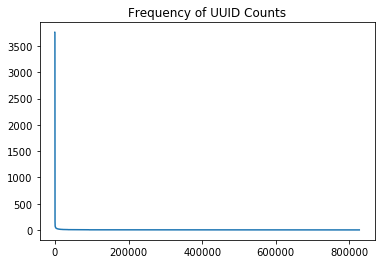

In [18]:
x = uuid_df['uuid'].value_counts().values
plt.plot(x)
plt.title('Frequency of UUID Counts')
plt.show();

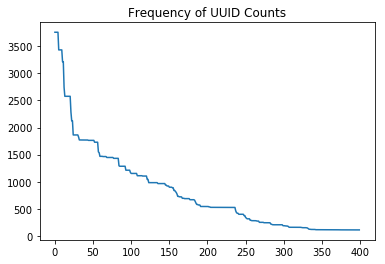

400th most common UUID occurs 108 times


In [19]:
x = uuid_df['uuid'].value_counts().values[:400]
plt.plot(x)
plt.title('Frequency of UUID Counts')
plt.show();

print '400th most common UUID occurs {} times'.format(uuid_df['uuid'].value_counts().values[400])


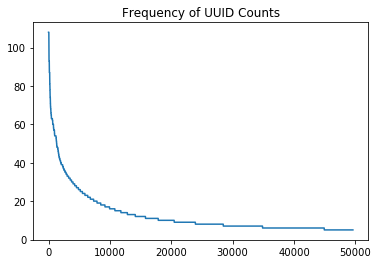

50,000th most common UUID occurs 5 times


In [20]:
x = uuid_df['uuid'].value_counts().values[400:50000]
plt.plot(x)
plt.title('Frequency of UUID Counts')
plt.show();
print '50,000th most common UUID occurs {} times'.format(uuid_df['uuid'].value_counts().values[50000])

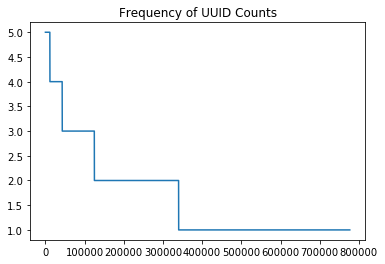

In [21]:
x = uuid_df['uuid'].value_counts().values[50000:]
plt.plot(x)
plt.title('Frequency of UUID Counts')
plt.show();

## Distribution by Day of Week

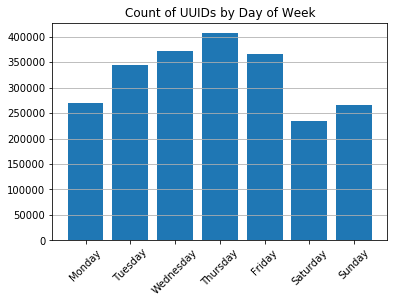

In [22]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

y = uuid_df['dow'].value_counts(normalize=False, sort=False).values
x = uuid_df['dow'].value_counts(normalize=False, sort=False).index
plt.bar(x, y)
plt.xticks(x, dayOfWeek.values())
plt.title('Count of UUIDs by Day of Week')
ax = plt.axes()        
ax.yaxis.grid()
plt.xticks(rotation=45)
plt.show()

## Distribution by Road Type
##### Questions:  

Why no road type 5?  What's up with road_type 17 and 20?
- 17 is Torrey Pines Park Rd, Liberator Way, NaN, Russ Blvd
- 20 is NaN, Alley, Pacific Ln, Rent A Car Access

In [23]:
uuid_df['road_type'].value_counts(normalize=False, sort=False)

1     363300
2     378509
3     162615
4     167219
6     447166
7     727918
17       663
20     13600
Name: road_type, dtype: int64

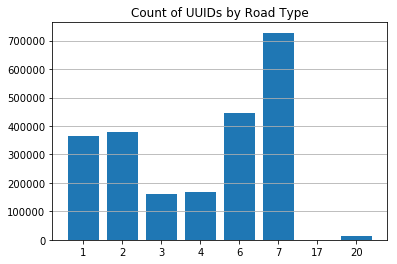

In [24]:
y = uuid_df['road_type'].value_counts(normalize=False, sort=False).values
x = range(1,len(y)+1)
plt.bar(x, y)
plt.xticks(x, uuid_df['road_type'].value_counts(normalize=False, sort=False).index)
plt.title('Count of UUIDs by Road Type')
ax = plt.axes()
ax.yaxis.grid()
plt.show()

In [25]:
uuid_df['road_type'].value_counts(normalize=False, sort=False)

1     363300
2     378509
3     162615
4     167219
6     447166
7     727918
17       663
20     13600
Name: road_type, dtype: int64

In [26]:
uuid_df[uuid_df['road_type']==20]['street'].value_counts()

NaN                  9995
Alley                3479
Pacific Ln             76
Rent A Car Access      50
Name: street, dtype: int64

In [27]:
uuid_df[uuid_df['road_type']==17]['street'].value_counts()

Torrey Pines Park Rd    486
Liberator Way            92
NaN                      54
Russ Blvd                31
Name: street, dtype: int64

## Most commonly occurring streets

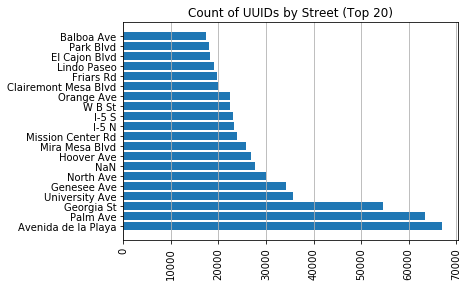

In [28]:
topn = 20
y = uuid_df['street'].value_counts(normalize=False, sort=True).values[:topn]
x = range(topn)
xticks = uuid_df['street'].value_counts(normalize=False, sort=True).index[:topn]

# change rcParam for fig height based on number of streets to display
plt.rcParams['figure.figsize']=(6, topn / 5)
plt.barh(x, y)
plt.yticks(x, xticks)
plt.title('Count of UUIDs by Street (Top {})'.format(topn))
ax = plt.axes()
ax.xaxis.grid()
plt.xticks(rotation=90)
plt.show()

# reset rcParams
plt.rcParams['figure.figsize']=(6, 4)

## Occurrences by Date / Time window
##### Questions:  
What happened on June 4th?
- Annual Rock 'n' Roll Marathon and Half Marathon

Use following query in PostGIS:
```
select * from events where cast(event_start as date) = '2017-06-04'
```

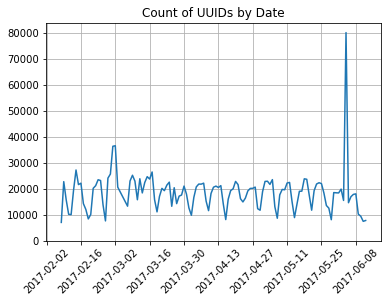

In [29]:
# count of uuids by date
y = uuid_df['date'].value_counts(sort=False).sort_index().values
x = uuid_df['date'].value_counts(sort=False).sort_index().index
plt.plot(x, y)
#plt.xticks(x)
plt.title('Count of UUIDs by Date')
plt.grid()
ax = plt.axes()
ax.set_ylim(ymin=0)
plt.xticks(rotation=45)
plt.show()

In [30]:
uuid_df['date'].value_counts().head(10)

2017-06-04    80125
2017-03-02    36527
2017-03-01    36317
2017-02-14    27184
2017-03-17    26419
2017-02-28    25614
2017-03-09    25159
2017-03-15    24609
2017-02-27    24045
2017-03-12    23806
Name: date, dtype: int64

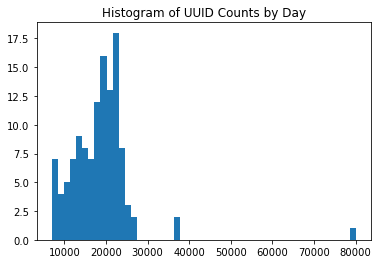

In [31]:
plt.hist(y, bins=50)
plt.title('Histogram of UUID Counts by Day')
plt.show();

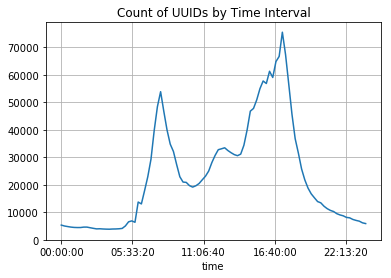

In [32]:
# count of uuids by time window
y = uuid_df['timeOnlyInterval'].value_counts(sort=False).sort_index().values
x = uuid_df['timeOnlyInterval'].value_counts(sort=False).sort_index().index
plt.plot(x, y)
#plt.xticks(x)
plt.title('Count of UUIDs by Time Interval')
ax = plt.axes()
ax.set_ylim(ymin=0)
plt.grid()
plt.show()

# Time duration of each UUID

###### Questions:
What's up with durations longer than anyone would reasonably ever sit in traffic?
__* These appear to be bad data, with duplicated UUIDs - see "Can UUIDs cross multiple streets" below *__

What's up with UUIDs that have timestamp ranges spanning 40+ days, but a small number of timestamps (rows of data)?

In [33]:
ts_df = uuid_df.groupby(['uuid']).agg({'waze_timestamp':[np.min, np.max, 'count']})
ts_df.columns = ['min_ts', 'max_ts', 'count']

In [34]:
ts_df['duration'] = ts_df['max_ts'] - ts_df['min_ts']
ts_df['duration_min'] = ts_df['duration'].values / np.timedelta64(1, 'm')

ts_df.sort_values(by='count', ascending=False).head()

,min_ts,max_ts,count,duration,duration_min
uuid,,,,,
977507871,2017-05-07 02:26:48,2017-05-20 04:57:19,3760,13 days 02:30:31,18870.516667
977765890,2017-05-07 02:26:48,2017-05-20 04:57:19,3760,13 days 02:30:31,18870.516667
977509981,2017-05-07 02:26:48,2017-05-20 04:57:19,3760,13 days 02:30:31,18870.516667
973869277,2017-05-07 02:26:48,2017-05-20 04:57:19,3760,13 days 02:30:31,18870.516667
975567875,2017-05-07 02:26:48,2017-05-20 04:57:19,3760,13 days 02:30:31,18870.516667


In [35]:
ts_df[ts_df['duration_min']>(40*60*24)]['count'].max()

30

In [36]:
ts_df.sort_values(by='duration', ascending=False).head(90)

,min_ts,max_ts,count,duration,duration_min
uuid,,,,,
2001998475,2017-02-09 08:37:20,2017-05-29 17:37:02,4,109 days 08:59:42,157499.700000
2038394035,2017-02-10 11:36:43,2017-05-30 15:22:15,3,109 days 03:45:32,157185.533333
2084620485,2017-02-11 19:26:19,2017-05-31 16:41:50,3,108 days 21:15:31,156795.516667
2080284583,2017-02-11 18:31:31,2017-05-31 15:01:16,2,108 days 20:29:45,156749.750000
2126598295,2017-02-13 11:42:21,2017-06-01 15:51:28,10,108 days 04:09:07,155769.116667
11643126,2017-02-14 08:21:22,2017-06-02 11:32:05,8,108 days 03:10:43,155710.716667
9712764,2017-02-14 09:01:49,2017-06-02 10:27:15,4,108 days 01:25:26,155605.433333
2129355020,2017-02-13 14:51:36,2017-06-01 15:46:40,2,108 days 00:55:04,155575.066667
2134101290,2017-02-13 17:16:50,2017-06-01 18:07:07,6,108 days 00:50:17,155570.283333


In [37]:
zero_duration_uuids = ts_df.loc[ts_df['duration_min']==0,:].index.values

len(zero_duration_uuids)

447453

In [38]:
ts_df.loc[31929]

min_ts          2017-04-14 12:41:57
max_ts          2017-04-14 12:41:57
count                             1
duration            0 days 00:00:00
duration_min                      0
Name: 31929, dtype: object

In [39]:
uuid_df[uuid_df['uuid'].isin(zero_duration_uuids)]

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
8,349775633,2017-02-24 08:51:49,Beyer Blvd,7,475,3,128,"LINESTRING(-117.060709 32.565916,-117.061494 3...",7,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
10,349870513,2017-02-24 08:51:49,L St,2,609,3,85,"LINESTRING(-117.069981 32.621575,-117.07022 32...",10,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
11,350481290,2017-02-24 08:51:49,Lane Ave,1,783,2,65,"LINESTRING(-116.961968 32.656595,-116.962041 3...",14,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
19,351753828,2017-02-24 08:51:49,Mira Mesa Blvd,6,1553,2,94,"LINESTRING(-117.181047 32.905541,-117.184295 3...",11,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
21,348543225,2017-02-24 08:51:49,Exit 29: Genesee Ave,4,443,3,114,"LINESTRING(-117.227976 32.883287,-117.227922 3...",10,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
26,349869223,2017-02-24 08:51:49,Camino Santa Fe,7,478,3,80,"LINESTRING(-117.170761 32.903363,-117.17091 32...",8,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
33,349489624,2017-02-24 08:51:49,Linda Vista Rd,7,648,3,90,"LINESTRING(-117.169072 32.788293,-117.16842 32...",7,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
34,351062549,2017-02-24 08:51:49,Camino Santa Fe,7,1054,2,69,"LINESTRING(-117.168019 32.891533,-117.168078 3...",18,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
40,350425740,2017-02-24 08:51:49,Carmel Mountain Rd,7,496,3,95,"LINESTRING(-117.232374 32.919268,-117.232052 3...",9,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
44,350798671,2017-02-24 08:56:36,Scranton Rd,2,350,3,109,"LINESTRING(-117.202147 32.894483,-117.20193 32...",10,4,2017-02-24,08:56:36,2017-02-24 08:45:00,08:45:00


In [40]:
ts_df['duration_min'].value_counts().head()

0.000000    447453
4.783333     81830
4.800000     57920
9.583333     19494
4.816667     16860
Name: duration_min, dtype: int64

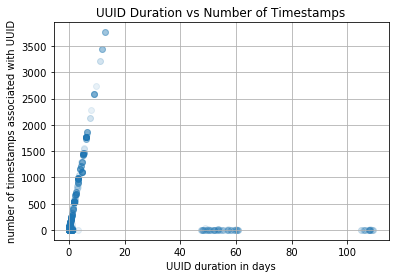

In [41]:
x = ts_df['duration_min'].values / (60.0 * 24)
y = ts_df['count'].values
plt.rcParams['figure.figsize'] = [6,4]
plt.scatter(x, y, alpha=0.1)
plt.grid()
plt.ylabel('number of timestamps associated with UUID')
plt.xlabel('UUID duration in days')
plt.title('UUID Duration vs Number of Timestamps')
plt.show();

# Linestring length distribution

In [42]:
uuid_df['linestring_length'].value_counts().head()

2    347240
3    194075
4    149147
5    145299
6    143073
Name: linestring_length, dtype: int64

In [43]:
uuid_df['linestring_length'].value_counts().tail()

227    1
254    1
241    1
242    1
292    1
Name: linestring_length, dtype: int64

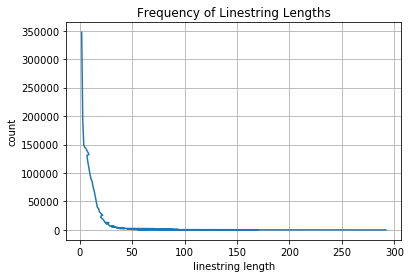

In [44]:
x = uuid_df['linestring_length'].value_counts().index
y = uuid_df['linestring_length'].value_counts().values

plt.plot(x, y)
plt.title('Frequency of Linestring Lengths')
plt.xlabel('linestring length')
plt.ylabel('count')
plt.grid()
plt.show();

In [45]:
uuid_df[uuid_df['linestring_length']>50].shape

(45409, 14)

# Can UUIDs cross multiple streets?
Yes, 89 UUIDs include 2 streets.  The remaining 826,571 include only 1 street.

Upon inspection, the UUIDs that include 2 streets look like bad data.  Comparing the differences between the min and max timestamps for these UUIDs, it looks like they correspond to the UUIDs with durations > 40 days in the graph above titled "UUID Duration vs Number of Timestamps".

So it appears that for some reason some UUIDs are used twice, and these account for those that have extremely long durations.  Of the UUIDs that occur on a single street, the max duration is 13 days, and nearly all of those that last more than 1 day are due to closed roads.

In [50]:
uuid_street_counts = uuid_df.groupby(['uuid'])['street'].nunique()

In [53]:
uuid_street_counts.value_counts()

1    826571
2        89
Name: street, dtype: int64

In [73]:
uuid_multiple_streets = uuid_street_counts[uuid_street_counts > 1]
uuid_single_streets = uuid_street_counts[uuid_street_counts == 1]

In [74]:
uuid_df_multiple_streets = uuid_df[uuid_df['uuid'].isin(uuid_multiple_streets.index)].copy()
uuid_df_single_streets = uuid_df[uuid_df['uuid'].isin(uuid_single_streets.index)].copy()

In [75]:
# sort by uuid so we see what streets
uuid_df_multiple_streets.sort_values(by='uuid', inplace=True)

In [76]:
uuid_df_multiple_streets.head()

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
1778474,9712764,2017-06-02 10:27:15,Campus Point Dr,1,295,3,84,"LINESTRING(-117.223751 32.879896,-117.223619 3...",7,4,2017-06-02,10:27:15,2017-06-02 10:15:00,10:15:00
1778423,9712764,2017-06-02 10:22:28,Campus Point Dr,2,823,3,147,"LINESTRING(-117.220178 32.88206,-117.220543 32...",22,4,2017-06-02,10:22:28,2017-06-02 10:15:00,10:15:00
1778386,9712764,2017-06-02 10:16:28,Campus Point Dr,2,957,3,106,"LINESTRING(-117.220178 32.88206,-117.220543 32...",25,4,2017-06-02,10:16:28,2017-06-02 10:15:00,10:15:00
2082564,9712764,2017-02-14 09:01:49,Adams Ave,2,346,3,99,"LINESTRING(-117.111036 32.763289,-117.110051 3...",6,1,2017-02-14,09:01:49,2017-02-14 09:00:00,09:00:00
917578,10041590,2017-04-14 16:22:22,Broadway,2,634,2,70,"LINESTRING(-117.080793 32.608794,-117.079998 3...",7,4,2017-04-14,16:22:22,2017-04-14 16:15:00,16:15:00


#### Below calculates the difference between the max and min dates for the UUIDs that include 2 streets.  These (large) differences seem to correspond to the UUIDs with durations > 40 days in the above graph titled "UUID Duration vs Number of Timestamps".

In [79]:
uuid_multiple_streets_durations = uuid_df_multiple_streets.groupby(['uuid'])['date'].max() - uuid_df_multiple_streets.groupby(['uuid'])['date'].min()

In [82]:
uuid_multiple_streets_durations.sort_values(inplace=True)

In [83]:
uuid_multiple_streets_durations.head()

uuid
387764309   47 days
190085206   48 days
394871534   48 days
74214548    48 days
74062304    48 days
Name: date, dtype: timedelta64[ns]

In [84]:
uuid_multiple_streets_durations.tail()

uuid
2134101290   108 days
2038394035   109 days
2080284583   109 days
2084620485   109 days
2001998475   109 days
Name: date, dtype: timedelta64[ns]

#### Now look at durations of the UUIDs that occur on a single street

In [77]:
uuid_df_single_streets.head()

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
0,348279374,2017-02-24 08:47:01,Rosecrans St,6,934,4,464,"LINESTRING(-117.205146 32.75087,-117.205464 32...",21,4,2017-02-24,08:47:01,2017-02-24 08:45:00,08:45:00
1,348764673,2017-02-24 08:47:01,to SR-163 N,4,487,3,101,"LINESTRING(-117.154769 32.724825,-117.154914 3...",14,4,2017-02-24,08:47:01,2017-02-24 08:45:00,08:45:00
2,348536095,2017-02-24 08:47:01,Via Rancho Pkwy,7,637,2,90,"LINESTRING(-117.074149 33.070687,-117.071046 3...",5,4,2017-02-24,08:47:01,2017-02-24 08:45:00,08:45:00
3,40791027,2017-02-24 08:51:49,Hoover Ave,1,100,5,-1,"LINESTRING(-117.104636 32.664031,-117.10495 32...",2,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00
4,36971633,2017-02-24 08:51:49,Hoover Ave,1,100,5,-1,"LINESTRING(-117.10495 32.664898,-117.104636 32...",2,4,2017-02-24,08:51:49,2017-02-24 08:45:00,08:45:00


In [85]:
uuid_single_streets_durations = uuid_df_single_streets.groupby(['uuid'])['date'].max() - uuid_df_single_streets.groupby(['uuid'])['date'].min()

In [86]:
uuid_single_streets_durations.sort_values(inplace=True)

In [87]:
uuid_single_streets_durations.head()

uuid
4606         0 days
1427415172   0 days
1427421632   0 days
1427424129   0 days
1427424269   0 days
Name: date, dtype: timedelta64[ns]

In [88]:
uuid_single_streets_durations.tail()

uuid
975567875   13 days
973869277   13 days
977507871   13 days
977509981   13 days
977765890   13 days
Name: date, dtype: timedelta64[ns]

In [89]:
uuid_single_streets_durations.value_counts()

0 days     825848
1 days        516
3 days         51
6 days         39
2 days         35
5 days         33
4 days         24
9 days          8
12 days         7
13 days         5
7 days          3
8 days          1
10 days         1
Name: date, dtype: int64

#### Some of the UUIDs that occur on a single street span up to 13 days.  Below we look at those that last more than 1 day

In [149]:
cutoff = np.timedelta64(1, 'D')
uuid_single_street_cutoff = uuid_single_streets_durations[uuid_single_streets_durations > cutoff]

In [150]:
uuid_df_single_streets_cutoff = uuid_df[uuid_df['uuid'].isin(uuid_single_street_cutoff.index)].copy()

In [151]:
uuid_df_single_streets_cutoff.sort_values(by=['uuid','waze_timestamp'], inplace=True)

In [152]:
uuid_df_single_streets_cutoff

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
1789200,33262227,2017-06-02 17:02:29,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:02:29,2017-06-02 17:00:00,17:00:00
1789411,33262227,2017-06-02 17:07:03,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:07:03,2017-06-02 17:00:00,17:00:00
1789611,33262227,2017-06-02 17:11:50,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:11:50,2017-06-02 17:00:00,17:00:00
1789832,33262227,2017-06-02 17:16:38,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:16:38,2017-06-02 17:15:00,17:15:00
1790078,33262227,2017-06-02 17:21:28,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:21:28,2017-06-02 17:15:00,17:15:00
1790324,33262227,2017-06-02 17:27:26,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:27:26,2017-06-02 17:15:00,17:15:00
1790585,33262227,2017-06-02 17:32:14,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:32:14,2017-06-02 17:30:00,17:30:00
1790845,33262227,2017-06-02 17:37:02,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:37:02,2017-06-02 17:30:00,17:30:00
1791046,33262227,2017-06-02 17:41:51,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:41:51,2017-06-02 17:30:00,17:30:00
1791220,33262227,2017-06-02 17:46:39,NaN,1,191,5,-1,"LINESTRING(-117.20445 32.729794,-117.204412 32...",12,4,2017-06-02,17:46:39,2017-06-02 17:45:00,17:45:00


In [153]:
uuid_df_single_streets_cutoff['delay'].value_counts()

-1      279580
 339         1
 81          1
 77          1
 75          1
Name: delay, dtype: int64

#### Almost all of these involved closed lanes, so filter those out and look at the few with moving lanes

In [154]:
uuid_df_ssc_moving = uuid_df_single_streets_cutoff[uuid_df_single_streets_cutoff['delay']!=-1]

In [155]:
uuid_df_ssc_moving

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
170676,501381810,2017-03-03 12:01:57,San Pasqual Valley Rd,7,3149,1,81,"LINESTRING(-116.946347 33.090601,-116.944471 3...",73,4,2017-03-03,12:01:57,2017-03-03 12:00:00,12:00:00
1649007,1806559534,2017-05-25 08:02:21,Bear Valley Pkwy,6,2919,3,339,"LINESTRING(-117.055158 33.102367,-117.055303 3...",39,3,2017-05-25,08:02:21,2017-05-25 08:00:00,08:00:00
1702935,1806559534,2017-05-28 12:32:00,Bear Valley Pkwy,6,1729,2,77,"LINESTRING(-117.054929 33.102686,-117.055158 3...",26,6,2017-05-28,12:32:00,2017-05-28 12:30:00,12:30:00
1703046,1806559534,2017-05-28 12:36:46,Bear Valley Pkwy,6,1729,2,75,"LINESTRING(-117.054929 33.102686,-117.055158 3...",26,6,2017-05-28,12:36:46,2017-05-28 12:30:00,12:30:00


In [156]:
uuid_df[uuid_df['uuid']==501381810]

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
90610,501381810,2017-03-01 00:01:41,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:01:41,2017-03-01 00:00:00,00:00:00
90641,501381810,2017-03-01 00:06:28,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:06:28,2017-03-01 00:00:00,00:00:00
90672,501381810,2017-03-01 00:11:15,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:11:15,2017-03-01 00:00:00,00:00:00
90703,501381810,2017-03-01 00:17:13,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:17:13,2017-03-01 00:15:00,00:15:00
90734,501381810,2017-03-01 00:22:00,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:22:00,2017-03-01 00:15:00,00:15:00
90765,501381810,2017-03-01 00:26:47,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:26:47,2017-03-01 00:15:00,00:15:00
90796,501381810,2017-03-01 00:31:34,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:31:34,2017-03-01 00:30:00,00:30:00
90827,501381810,2017-03-01 00:36:21,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:36:21,2017-03-01 00:30:00,00:30:00
90858,501381810,2017-03-01 00:42:20,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:42:20,2017-03-01 00:30:00,00:30:00
90896,501381810,2017-03-01 00:47:07,San Pasqual Valley Rd,7,2974,5,-1,"LINESTRING(-116.944471 33.090617,-116.944192 3...",72,2,2017-03-01,00:47:07,2017-03-01 00:45:00,00:45:00


In [157]:
uuid_df[uuid_df['uuid']==1806559534]

,uuid,waze_timestamp,street,road_type,length,level,delay,linestring,linestring_length,dow,date,timeOnly,interval,timeOnlyInterval
1649007,1806559534,2017-05-25 08:02:21,Bear Valley Pkwy,6,2919,3,339,"LINESTRING(-117.055158 33.102367,-117.055303 3...",39,3,2017-05-25,08:02:21,2017-05-25 08:00:00,08:00:00
1702935,1806559534,2017-05-28 12:32:00,Bear Valley Pkwy,6,1729,2,77,"LINESTRING(-117.054929 33.102686,-117.055158 3...",26,6,2017-05-28,12:32:00,2017-05-28 12:30:00,12:30:00
1703046,1806559534,2017-05-28 12:36:46,Bear Valley Pkwy,6,1729,2,75,"LINESTRING(-117.054929 33.102686,-117.055158 3...",26,6,2017-05-28,12:36:46,2017-05-28 12:30:00,12:30:00


#### Looks like one of these (uuid 501381810) is a closed lane that opened up, while the other (uuid 1806559534) may be bad data, since one of the timestamps is 3 days different than the others.